## Librerias

In [1]:
## Manipulación de datos
import pandas as pd
import numpy as np

## Visualización
import matplotlib.pyplot as plt
import seaborn as sns

## Requests images
import urllib.request
from PIL import Image

## Modelos
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler,PolynomialFeatures
from sklearn.metrics import root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("../Data/Processed/train_clean.csv")

In [3]:
train.head()

,laptop_ID,TypeName,Inches,Touchscreen,ProcessorType,ModelIdentifier,Core,ProcessorSpeed(GHz),Ram(GB),Memory SSD GB,...,"PanelType_IPS Panel, Quad HD+","PanelType_IPS Panel, Retina Display",PanelType_No penal type,PanelType_Quad HD+,OpSys_Android,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS,OpSys_No OS,OpSys_Windows
0,599,1,11.6,1,9.0,730,0.0,1.0,4,128.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,92,2,15.6,0,10.0,9830,0.0,3.0,8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,744,3,15.6,0,1.0,7700,0.0,2.8,16,256.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,729,1,13.3,1,5.0,7200,0.0,2.5,8,256.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,957,4,15.6,0,5.0,6200,0.0,2.3,8,256.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
df = train.copy()

In [5]:
df['ProcessorType'] = df['ProcessorType'].fillna(15)

### 1. Definir X e y

In [6]:
# X = df.drop(['Price_euros'], axis=1)
# y = df['Price_euros'].copy()
X = df.drop(['Price_euros'], axis=1)
y = df['Price_euros'].values.reshape(-1, 1)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
scaler_y = np.sqrt(y)

### 2. Dividir X_train, X_test, y_train, y_test

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, scaler_y, test_size = 0.20, random_state = 42)

In [8]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    bootstrap=True,
    random_state=42
)

# Entrenar el modelo en los datos de entrenamiento
rf.fit(X_train, y_train.ravel())

# Seleccionar características más importantes con `SelectFromModel`
selector = SelectFromModel(rf, threshold="median", prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Escalamos los datos con RobustScaler
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train_selected)
X_test_scaled = scaler_X.transform(X_test_selected)

# Entrenar `RandomForestRegressor` en los datos transformados
rf_selected = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    bootstrap=True,
    random_state=42
)
rf_selected.fit(X_train_scaled, y_train.ravel())

# Hacer predicciones en `X_test`ya escalado
y_pred_rf = rf_selected.predict(X_test_scaled)

# Calculamos el RMSE
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
print(f"✅ RMSE Random Forest: {rmse_rf:.4f}")

✅ RMSE Random Forest: 3.2322


#### Resumen general de todas las X, de aca podemos observar variables significativas para el modelo o no.

In [9]:
X_train_scaled = sm.add_constant(X_train_scaled, prepend=True)
modelo_interacion  = sm.OLS(endog=y_train, exog=X_train,)
modelo_interacion  = modelo_interacion.fit()
print(modelo_interacion.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     54.22
Date:                Tue, 04 Feb 2025   Prob (F-statistic):          1.22e-202
Time:                        14:20:39   Log-Likelihood:                -2107.3
No. Observations:                 729   AIC:                             4317.
Df Residuals:                     678   BIC:                             4551.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
la

#### En este grafico podemos observas las features con mas importancia y las que menos.

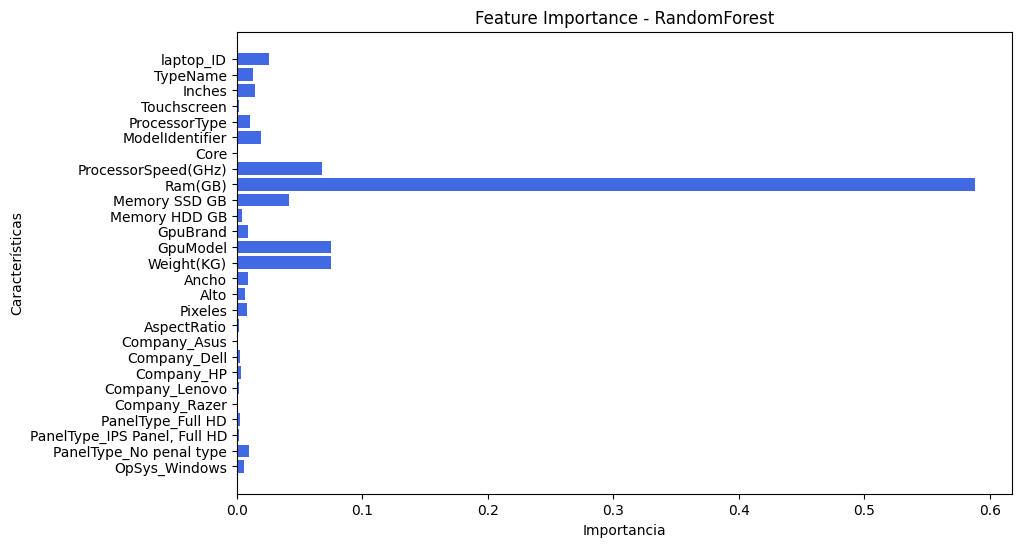

In [10]:
feature_importances = rf_selected.feature_importances_

# Obtener los nombres de las características seleccionadas
selected_feature_names = X_train.columns[selector.get_support()]  # Obtener solo las columnas seleccionadas

# Crear un DataFrame con la importancia de las características
feature_importance_df = pd.DataFrame({
    "Feature": selected_feature_names,  # Usar los nombres reales de las columnas seleccionadas
    "Importance": feature_importances
})

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="royalblue")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Feature Importance - RandomForest")
plt.gca().invert_yaxis()  # Invertir el eje Y para que las más importantes estén arriba
plt.show()

### Aca cargaremos datos desde otro csv para pdoer predecir el precio de los PC teniendo en cuenta sus especificaciones. (a este csv se le ha aplicado la misma limpieza que al de entrenamiento.)

In [11]:
X_pred = pd.read_csv("../Data/Processed/test_clean.csv")

In [13]:
X_train_poly_df = pd.DataFrame(X_train, columns=poly.get_feature_names_out())
# Transformamos en DF a X_train (con el metodo POLY aplicado).

In [14]:
X_pred = X_pred[[col for col in X_train_poly_df.columns if col in X_pred.columns]]
# Esta lista de compresion es para segurarnos que los datos del csv a predecir,
#  tengan el mismo orden y las mismas columnas que X_train con el metodo POLY.

In [15]:
X_poly_pred = poly.transform(X_pred)
# Aplicamos el metodo POLY a los datos del csv.

In [16]:
X_pred_selected = selector.transform(X_pred)
# Aplicamos el selector de caracteristicas mas importantes a los datos a predecir (con los datos transformados).

X_poly_pred_scaled = scaler_X.transform(X_pred_selected) 
# Aplicamos el scaler a los datos a predeci (con los datos transformados con el metodo POLY).

predictions_scaled = rf_selected.predict(X_poly_pred_scaled)
# Realizamos prediccion.

predictions_submit = np.square(predictions_scaled)
# Aplicamos sqrt en y, la regresamos a su valor original

predictions_submit[:10]
# Mostramos algunas predicciones

array([1227.83501443, 1165.46976013,  261.07986758, 1914.72206815,
       1472.22818522,  387.69174074, 2614.72337824,  467.14260689,
       1748.43189146,  823.59361141])